# Satellite based Thailand Rainfall Data Visualization
- Data source: http://chrsdata.eng.uci.edu/
- PERSIANN-CCS (4x4 km) 2013 to 2019-10-02


## 1. Install library:

xarray for data handling
- conda install xarray dask netCDF4 bottleneck
- or pip install xarray 

Cartopy for visualization with map
- pip install Cartopy 
  

## 2. Read NetCDF data to xarray

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# load all nc files
mfdataDIR = 'CCS_country_daily_20030101-20191002/*.nc'
DS = xr.open_mfdataset(mfdataDIR, combine='by_coords')

In [2]:
DS # see data structure

<xarray.Dataset>
Dimensions:   (datetime: 6119, lat: 373, lon: 210)
Coordinates:
  * lon       (lon) float32 97.32 97.36 97.4 97.44 ... 105.6 105.64 105.68
  * lat       (lat) float32 20.52 20.48 20.44 20.4 20.36 ... 5.76 5.72 5.68 5.64
  * datetime  (datetime) datetime64[ns] 2003-01-01 2003-01-02 ... 2019-10-02
Data variables:
    crs       (datetime) int32 -2147483647 -2147483647 ... -2147483647
    precip    (datetime, lat, lon) int16 dask.array<chunksize=(365, 373, 210), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

### 2.1 Plot data sample

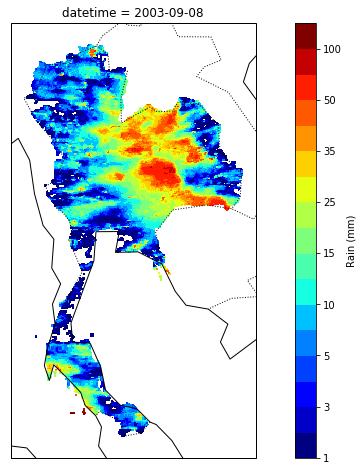

In [3]:
# select 1 day of data to plot
ds_oneday = DS.precip.isel(datetime=250)

# ignore blank data (outside Thailand)
ds_oneday = ds_oneday.where(ds_oneday != -99.).where(ds_oneday != 0)

# plot
plt.figure(figsize=(14, 8))
# create basemap and country boundary
ax = plt.axes(projection=ccrs.PlateCarree()) # this projection is not exactly the same as the data, because some point are outside of the border of the country
ax.coastlines() 
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
# colorbar
bounds = [1,2,3,4,5,7,10,13,15,20,25,30,35,40,50,75,100,150]
ds_oneday.plot(cmap=plt.cm.jet, levels=bounds, cbar_kwargs={'label': 'Rain (mm)'})

## 3. Select one specific point in data 

In [4]:
lat_lon = (13.73826, 100.532413)  # chula  13.73826, 100.532413

In [5]:
# find index from value in array https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx #array[idx]

#convert specified lat lon to index in data
lat_index = find_nearest_index(DS.lat, lat_lon[0])
lon_index = find_nearest_index(DS.lon, lat_lon[1])

lat_index, lon_index

(170, 80)

In [6]:
DS.lat[170] # closet lat value in array

<xarray.DataArray 'lat' ()>
array(13.72, dtype=float32)
Coordinates:
    lat      float32 13.72

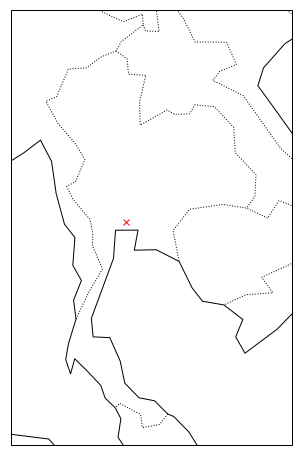

In [7]:
# plot marker on the map
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines() 
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.set_extent([96, 107, 5, 22]) # lat lon frame border

plt.plot(DS.lon[lon_index].values, DS.lat[lat_index].values,
         color='r', linewidth=1, marker='x',
         transform=ccrs.Geodetic(),
         )
plt.show()

### 3.1 Plot time series graph

([<matplotlib.axis.XTick at 0x209f6fd2c08>,
 <a list of 17 Text xticklabel objects>)

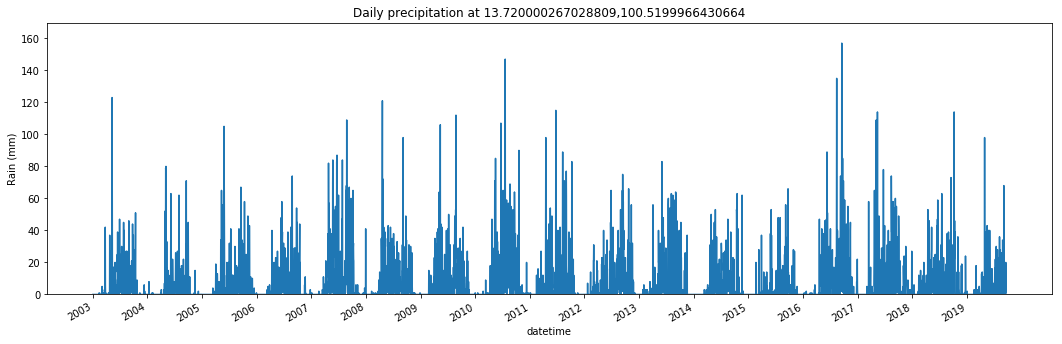

In [8]:
# select lat lon index from data
ds = DS.precip.isel(lat=lat_index, lon=lon_index)

# plot
plt.figure(figsize=(18,5))
ds.plot()
plt.title(f'Daily precipitation at {DS.lat[lat_index].values},{DS.lon[lon_index].values}')
plt.ylabel('Rain (mm)')
plt.ylim(ymin=0)
plt.xticks(DS.precip.datetime.values[::366])

### 3.2 Plot specific date range graph e.g. 1 year

Text(0.5,1,'Daily Rainfall in 2018')

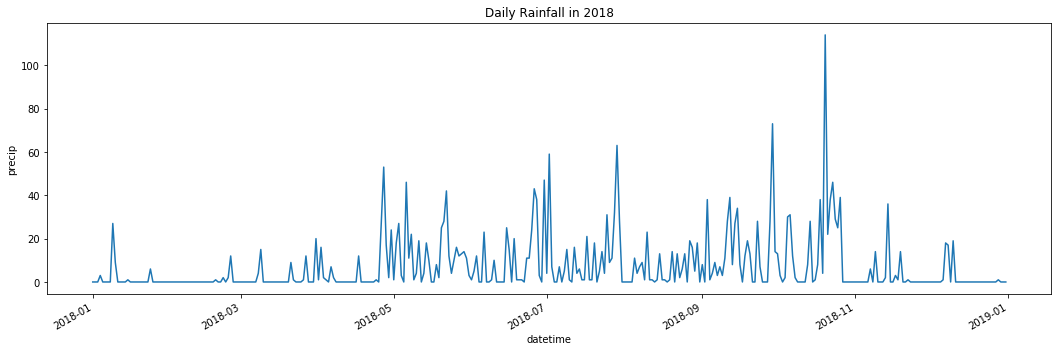

In [9]:
plt.figure(figsize=(18,5))
temp = ds.sel(datetime=slice('2018-01-01', '2018-12-31'))
temp.plot()
plt.title('Daily Rainfall in 2018')

### 3.3 Plot bar chart

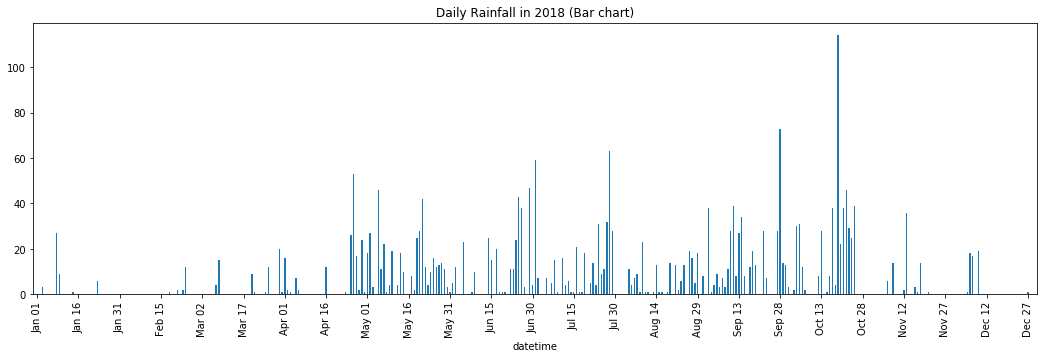

In [10]:
# convert xarray to pandas series 
rain_series = temp.to_series()

# plot in bar chart
plt.subplots(figsize=(18, 5))
ax = rain_series.plot.bar()
plt.title('Daily Rainfall in 2018 (Bar chart)')

# set x-axis label tick
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_ticks(np.arange(1, rain_series.shape[0], 15))

### 3.4 Plot yearly comparison graph

In [11]:
# convert xarray to dataframe
df = ds.to_dataframe().drop(columns=['lat','lon'])

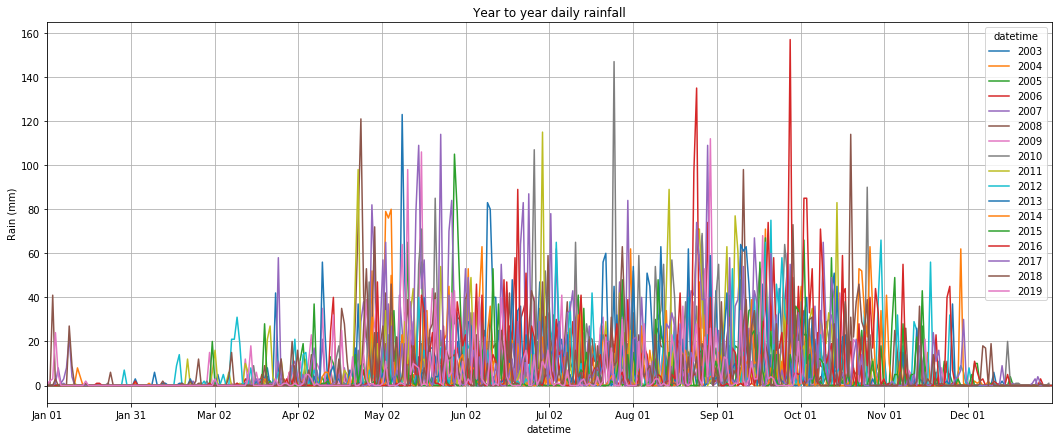

In [12]:
# remove some error points (-99)
df[df.precip < 0] = 0

# plot
pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                    values='precip')
ax = pv.plot(title=f"Year to year daily rainfall",figsize=(18,7), grid=True)
ax.set_ylabel('Rain (mm)')
#ax.set_xlabel('Day in year')

# set x-axis label tick
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
#set tick frequecy every month 
ax.xaxis.set_ticks(np.arange(1, 365, 365/12))